In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
from matplotlib.lines import lineStyles
sns.set(context="notebook", style="ticks")
plt.rcParams.update({"font.sans-serif": "Fira Sans Condensed"})

In [11]:
def calibration_curves(y_true, y_prob, y_pred, bins=10):
    real_probs = []
    pred_probs = []
    # count, lims = np.histogram(true_probs, bins=bins)
    count, lims = np.histogram(true_probs, range=(0., 1.), bins=bins)
    for i in range(bins):
        lower, upper = lims[i], lims[i+1]
        mask = (lower <= y_prob) & (y_prob < upper)
        # Find targets for which our prediction lies within a range
        targets_in_range = y_true[mask]
        preds_in_range = y_pred[mask]
        n_in_range = y_true[mask].shape[0]
        range_acc = np.sum(targets_in_range == preds_in_range) / n_in_range

        real_probs.append(range_acc)
        pred_probs.append((lower+upper)/2)
    return real_probs, pred_probs

In [12]:
eval_dataset = "mnist"

results = []
types = [
    "ensemble_5",
    "ensemble_10",
    "ensemble_20",
    "radial",
    "meanfield",
    "lowrank",
    "laplace",
    "ml",
    "map",
]
for type in types:
    with open(f"/home/silas/Documents/university/special-course/results/{type}.pkl", "rb") as f:
        data = pickle.load(f)[f"eval_{eval_dataset}"]
        results.append(data)
results = pd.DataFrame.from_dict(results)
results.insert(0, "Ensembles", types)
results

,Ensembles,NLL,Accuracy,AUROC,Average confidence,Average confidence when wrong,Average confidence when right,Test targets,Test probabilities
0,ensemble_5,0.114568,0.9794,0.999644,0.983222,0.734436,0.988454,"[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, ...","[[1.8481018e-07, 9.0609554e-08, 4.6647565e-05,..."
1,ensemble_10,0.116535,0.9800,0.999681,0.983533,0.730582,0.988696,"[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, ...","[[5.651249e-09, 9.463939e-08, 2.6626305e-06, 2..."
2,ensemble_20,0.117882,0.9796,0.999672,0.984044,0.727143,0.989394,"[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, ...","[[6.504901e-09, 2.6743063e-08, 1.4361391e-06, ..."
3,radial,0.147525,0.9661,0.999069,0.914409,0.561715,0.926785,"[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, ...","[[7.089057e-06, 0.00023821919, 0.00016588277, ..."
4,meanfield,0.210593,0.9528,0.997943,0.879601,0.538400,0.896503,"[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, ...","[[4.4745404e-05, 0.00039658777, 0.0016176066, ..."
5,lowrank,0.329365,0.9229,0.994062,0.825524,0.517801,0.851232,"[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, ...","[[0.00090713747, 0.00032452954, 0.0069206133, ..."
6,laplace,0.194089,0.9469,0.997292,0.917648,0.630463,0.933753,"[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, ...","[[2.476732e-06, 6.1201725e-05, 0.000978338, 0...."
7,ml,0.131273,0.9601,0.998844,0.953470,0.669937,0.965253,"[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, ...","[[1.19209275e-07, 3.848207e-05, 3.8949685e-05,..."
8,map,0.170223,0.9532,0.997666,0.937829,0.670489,0.950955,"[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, ...","[[2.5653919e-05, 7.603361e-05, 0.0005965173, 0..."


# Ensembles

In [13]:
eval_dataset = "mnist"

results = []
num_ensembles = [5, 10, 20]
for n in num_ensembles:
    with open(f"/home/silas/Documents/university/special-course/results/ensemble_{n}.pkl", "rb") as f:
        data = pickle.load(f)[f"eval_{eval_dataset}"]
        results.append(data)
results = pd.DataFrame.from_dict(results)
results.insert(0, "Ensembles", num_ensembles)

In [14]:
results

,Ensembles,NLL,Accuracy,AUROC,Average confidence,Average confidence when wrong,Average confidence when right,Test targets,Test probabilities
0,5,0.114568,0.9794,0.999644,0.983222,0.734436,0.988454,"[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, ...","[[1.8481018e-07, 9.0609554e-08, 4.6647565e-05,..."
1,10,0.116535,0.9800,0.999681,0.983533,0.730582,0.988696,"[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, ...","[[5.651249e-09, 9.463939e-08, 2.6626305e-06, 2..."
2,20,0.117882,0.9796,0.999672,0.984044,0.727143,0.989394,"[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, ...","[[6.504901e-09, 2.6743063e-08, 1.4361391e-06, ..."


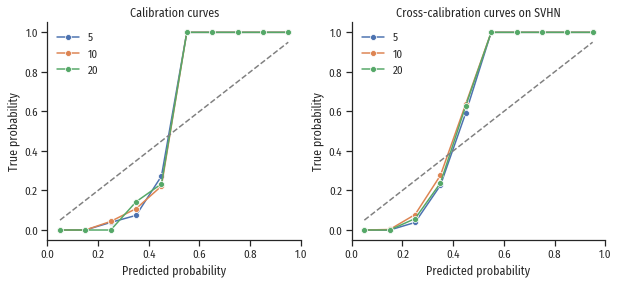

In [15]:
bins = 10

fig, ax = plt.subplots(ncols=2, figsize=(10,4))
for i, (dataset, title) in enumerate([("mnist", "Calibration curves"), ("svhn", "Cross-calibration curves on SVHN")]):
    for n in num_ensembles:
        with open(f"/home/silas/Documents/university/special-course/results/ensemble_{n}.pkl", "rb") as f:
            data = pickle.load(f)
            targets = data[f"eval_{dataset}"]["Test targets"][:,None]
            probs = data[f"eval_{dataset}"]["Test probabilities"]

            preds = np.argmax(probs, axis=1)[:, None]
            true_probs = np.take_along_axis(probs, targets, axis=1)
            prob_true, prob_pred = calibration_curves(targets, true_probs, preds, bins=bins)

            sns.lineplot(x=prob_pred, y=prob_true, marker="o", label=n, ax=ax[i])
            # ax.plot(prob_pred, prob_true, label=guide, marker="o")
    ax[i].plot(prob_pred, prob_pred, "--", color="grey")
    ax[i].set(
        xlabel="Predicted probability",
        ylabel="True probability",
        title=title,
        xlim=(0, 1),
    )
    ax[i].legend(frameon=False)
    # ax[i].set_aspect("equal", adjustable="box")
sns.despine(fig)


# Guides

In [16]:
guides = [
    "ml",
    "map",
    "laplace",
    "meanfield",
    "lowrank",
    "radial",
]
eval_dataset = "svhn"
results = []
for guide in guides:
    with open(f"/home/silas/Documents/university/special-course/results/{guide}.pkl", "rb") as f:
        data = pickle.load(f)
        row = [
            data["Inference"],
            data["Trained on"],
            data["Wall clock time"],
            data["Number of parameters"],
            data[f"eval_{eval_dataset}"]["NLL"],
            data[f"eval_{eval_dataset}"]["Accuracy"],
            data[f"eval_{eval_dataset}"]["AUROC"],
            data[f"eval_{eval_dataset}"]["Average confidence"],
            data[f"eval_{eval_dataset}"]["Average confidence when wrong"],
            data[f"eval_{eval_dataset}"]["Average confidence when right"],
        ]
        results.append(row)
results = pd.DataFrame(results, columns=["Inference", "Trained on", "Wall clock time", "Number of parameters", "NLL", "Accuracy", "AUROC", "Average confidence", "Average confidence when wrong", "Average confidence when right"])
results

,Inference,Trained on,Wall clock time,Number of parameters,NLL,Accuracy,AUROC,Average confidence,Average confidence when wrong,Average confidence when right
0,ml,mnist,1775.022648,26506,6.474030,0.131185,0.516628,0.743253,0.742588,0.747654
1,map,mnist,1918.449614,26506,6.423938,0.146512,0.500749,0.724624,0.722702,0.735820
2,laplace,mnist,1948.156711,26506,6.755862,0.134527,0.526427,0.748467,0.751279,0.730378
3,meanfield,mnist,2063.587869,53012,2.943526,0.135756,0.545311,0.386715,0.373529,0.470657
4,lowrank,mnist,7853.248097,4373490,2.499218,0.132913,0.555138,0.318362,0.304151,0.411067
5,radial,mnist,2114.385645,53012,2.868953,0.155194,0.544928,0.427744,0.405741,0.547520


'FiraSansCondensed-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


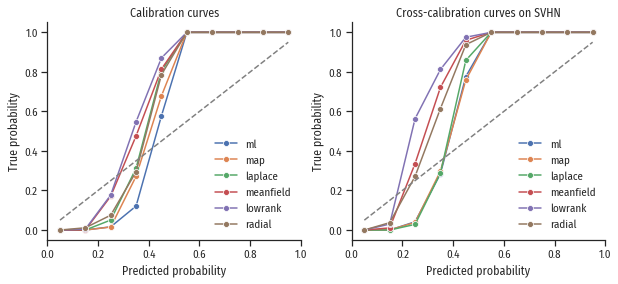

In [18]:
bins = 10

fig, ax = plt.subplots(ncols=2, figsize=(10,4))
for i, (dataset, title) in enumerate([("mnist", "Calibration curves"), ("svhn", "Cross-calibration curves on SVHN")]):
    for guide in guides:
        with open(f"/home/silas/Documents/university/special-course/results/{guide}.pkl", "rb") as f:
            data = pickle.load(f)

            targets = data[f"eval_{dataset}"]["Test targets"][:,None]
            probs = data[f"eval_{dataset}"]["Test probabilities"]

            preds = np.argmax(probs, axis=1)[:, None]
            true_probs = np.take_along_axis(probs, targets, axis=1)
            prob_true, prob_pred = calibration_curves(targets, true_probs, preds, bins=bins)

            sns.lineplot(x=prob_pred, y=prob_true, marker="o", label=guide, ax=ax[i])
            # ax.plot(prob_pred, prob_true, label=guide, marker="o")
    ax[i].plot(prob_pred, prob_pred, "--", color="grey")
    ax[i].set(
        xlabel="Predicted probability",
        ylabel="True probability",
        title=title,
        xlim=(0, 1),
    )
    ax[i].legend(frameon=False)
    # ax[i].set_aspect("equal", adjustable="box")
sns.despine(fig)
fig.savefig("cross-calibration.pdf")

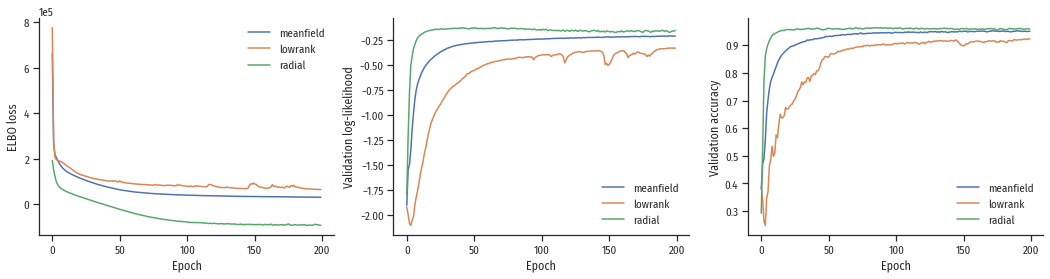

In [10]:
fig, ax = plt.subplots(ncols=3, figsize=(18,4))
for guide in [
    "meanfield",
    "lowrank",
    "radial",
]:
    with open(f"/home/silas/Documents/university/special-course/results/{guide}.pkl", "rb") as f:
        data = pickle.load(f)
        epochs = np.arange(len(data["Training ELBO"]))
        sns.lineplot(x=epochs, y=data["Training ELBO"].squeeze(), label=guide, ax=ax[0])
        sns.lineplot(x=epochs, y=data["Validation log-likelihood"].squeeze(), label=guide, ax=ax[1])
        sns.lineplot(x=epochs, y=data["Validation accuracy"].squeeze(), label=guide, ax=ax[2])
ax[0].set(
    xlabel="Epoch",
    ylabel="ELBO loss",
)
ax[1].set(
    xlabel="Epoch",
    ylabel="Validation log-likelihood",
)
ax[2].set(
    xlabel="Epoch",
    ylabel="Validation accuracy",
)
ax[0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax[0].legend(frameon=False)
ax[1].legend(frameon=False)
ax[2].legend(frameon=False)
sns.despine(fig)